# Projekt: Erkennung von Spurmarkierungen
In diesem Projekt sollen Spurmarkierungen in zwei bestehenden Datensätzen erkannt werden: 
1. Udacity Nanodegree "Self-Driving Car Engineer" (https://www.udacity.com/course/self-driving-car-engineer-nanodegree--nd0013)
2. KITTI-Datensatz zur Erkennung von Spurmarkierungen (http://www.cvlibs.net/datasets/kitti/eval_road.php)

In [2]:
import cv2 as cv
from matplotlib import pyplot as plt
import numpy as np
import os

print('Willkommen beim Projekt "Erkennung von Spurmarkierungen"')

Willkommen beim Projekt "Erkennung von Spurmarkierungen"


# Exkurs 1: Kamerakalibrierung zur Entzerrung der Bilder
Die vorhandenen Bilder sind aufgrund der Linsen- und Kameraeigenschaften verzerrt. Entzerren Sie die Bilder mithilfe der Kamerakalibrierungsroutinen von OpenCV (https://docs.opencv.org/4.5.3/dc/dbb/tutorial_py_calibration.html) und den aufgezeichneten Bildern.

In [97]:
import numpy as np
import cv2 as cv
import glob

# Code wurde überarbeitet von opencv.org/4.5.3/dc/dbb/tutorial_py_calibration.html

# termination criteria
criteria = (cv.TERM_CRITERIA_EPS + cv.TERM_CRITERIA_MAX_ITER, 30, 0.001)
# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)

cols = 9
rows = 6

objp = np.zeros((rows*cols,3), np.float32)
objp[:,:2] = np.mgrid[0:6,0:9].T.reshape(-1,2)
# Arrays to store object points and image points from all the images.
objpoints = [] # 3d point in real world space
imgpoints = [] # 2d points in image plane.
images = glob.glob(pathname='img/Udacity/calib/*.jpg')
for fname in images:
    img = cv.imread(fname)
    gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
    # Find the chess board corners
    ret, corners = cv.findChessboardCorners(gray, (rows,cols), None)
    # If found, add object points, image points (after refining them)
    if ret == True:
        objpoints.append(objp)
        corners2 = cv.cornerSubPix(gray,corners, (11,11), (-1,-1), criteria)
        imgpoints.append(corners2)

        # # Draw and display the corners
        # cv.drawChessboardCorners(img, (rows,cols), corners2, ret)
        # # plt.figure(figsize=(20,10))
        # plt.subplot(1,2,1)
        # plt.title(fname)
        # plt.imshow(img)

        # ret, mtx, dist, rvecs, tvecs = cv.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)
        # h,  w = img.shape[:2]
        # dst = cv.undistort(img, mtx, dist, None, mtx)
        # plt.subplot(1,2,2)
        # plt.imshow(dst)
        # plt.show()
    else:
        print("could not find corners")

ret, mtx, dist, rvecs, tvecs = cv.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)
print(mtx)
print(dist)

could not find corners
could not find corners
could not find corners
[[1.15694047e+03 0.00000000e+00 6.65948821e+02]
 [0.00000000e+00 1.15213880e+03 3.88784788e+02]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]
[[-2.37638058e-01 -8.54041696e-02 -7.90999653e-04 -1.15882218e-04
   1.05725981e-01]]


# Exkurs 2: Perspektivtransformation
Durch die Kameraperspektive wird die Krümmung der gefundenen Spurmarkierungen nicht der realen Fahrstreifenkrümmung entsprechen. Transformieren Sie daher die Bilder der Kameraperspektive in eine Vogelperspektive, die der realen Fahrstreifenkrümmung entspricht.

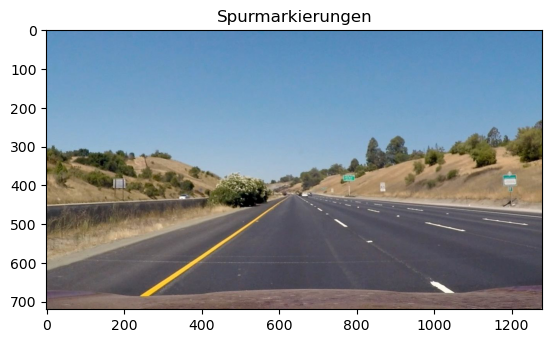

1280 720


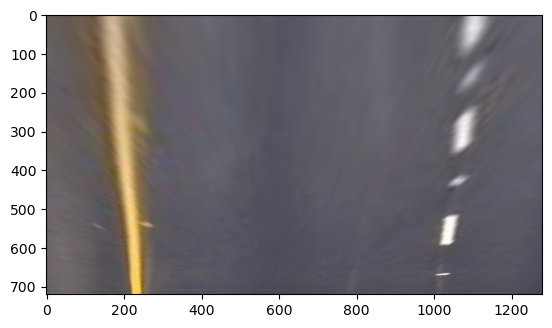

In [4]:
# einlesen eines Beispielbildes
img1 = cv.imread('./img/Udacity/image001.jpg', -1)
plt.imshow(cv.cvtColor(img1, cv.COLOR_BGR2RGB))
plt.title('Spurmarkierungen')
plt.show()

h,  w = img1.shape[:2]
print(w, h)

# definieren Sie die für eine Perspektivtransformation notwendigen Quell- und Zielpunkte
src = np.float32(((580, 450), (700, 450), (220, 600), (1100, 600)))
dst = np.float32(((0, 0), (w, 0), (0, h), (w, h)))



M = cv.getPerspectiveTransform(src,dst)
img1_warp = cv.warpPerspective(img1,M,(img1.shape[1], img1.shape[0]))
plt.imshow(cv.cvtColor(img1_warp, cv.COLOR_BGR2RGB))
plt.show()

# Aufgabe 3: Erkennung von Fahrbahnmarkierungen
Erkennen Sie die Fahrbahnmarkierungen bzw. Fahrstreifen auf den Bildquellen von Udacity. Wenden Sie dabei die aus der Vorlesung bekannten Verfahren an. Gerne dürfen Sie auch weitere Verfahren aus anderen Quellen verwenden. Folgende Ziele müssen bei der finalen Abgabe erreicht werden: 
- **Segmentierung**: schränken Sie das Bild auf den Bereich ein, in dem sich die Spurmarkierungen befinden
- **Vorverarbeitung**: führen Sie eine Kamerakalibrierung (für Udacity-Bildquellen) und die Perspektivtransformation durch
- **Farbräume, Histogramme**: erkennen Sie die Spurmarkierungen in den Farben der angegebenen Quellen. Sofern weitere Spurmarkierungen auf dem Bild gefunden werden, müssen diejenigen Spurmarkierungen priorisiert werden, die die eigene Fahrspur begrenzen
- **Allgemeines**: Die Verarbeitung von Bildern muss in Echtzeit stattfinden --> Ziel: > 20 FPS
- **Allgemeines**: Beschleunigen Sie die Verarbeitung durch weitere Maßnahmen weitere Maßnahmen überlegen (bspw. Erkennung der Spurmarkierung in den ersten Frames, Tracking der Spurmarkierung in weiteren Frames solange, bis sich Spurmarkierungspositionen zu stark ändern)
- **Minimal**: relevante Spurmarkierungen werden im Video "project_video" durchgehend erkannt 
- **Zusatz**: relevante Spurmarkierungen werden im Video "challenge_video" und "harder_challenge_video" durchgehend erkannt
- **Zusatz**: relevante Spurmarkierungen werden auf den Datensatz KITTI angewendet. Welche Anpassungen müssen vorgenommen werden, damit Ihr Algorithmus übertragen werden kann?
- **Zusatz**: Erarbeiten Sie weitere Maßnahmen zur Geschwindigkeitsverbesserung Ihres Algorithmus
- **Zusatz**: Erkennen Sie Objekte im Bild und visualisieren Sie diese (z.B. weitere Fahrzeuge, Motorräder, etc.)Die Objekterkennung bitte so implementieren, dass sie deaktivierbar ist und nicht in FPS-Berechnung einzahlt.

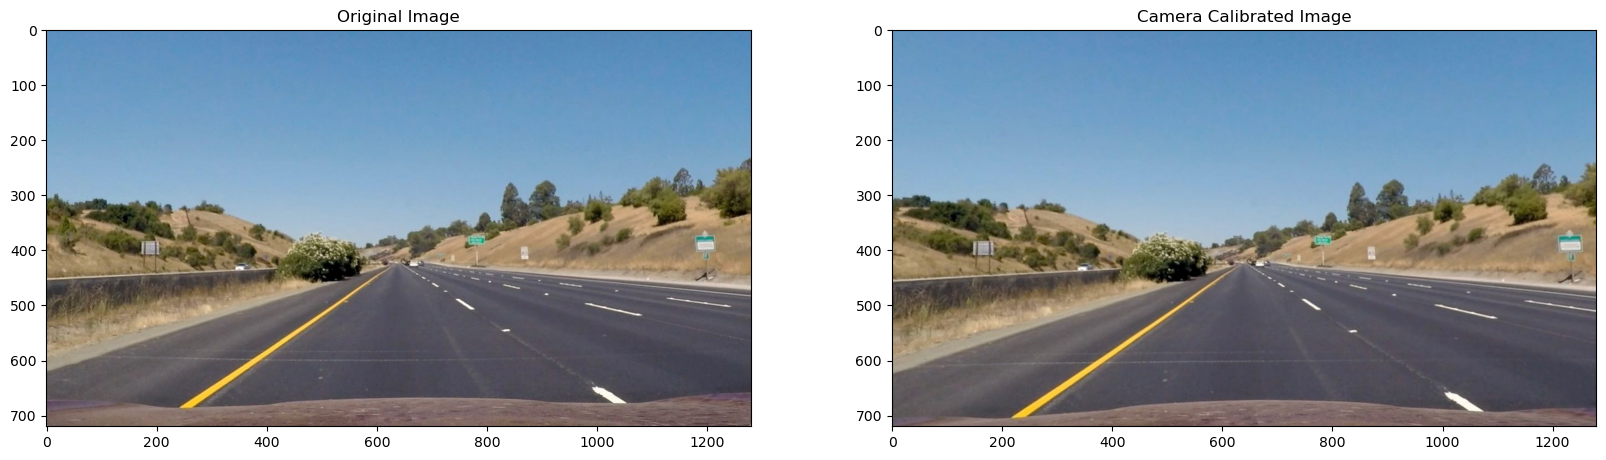

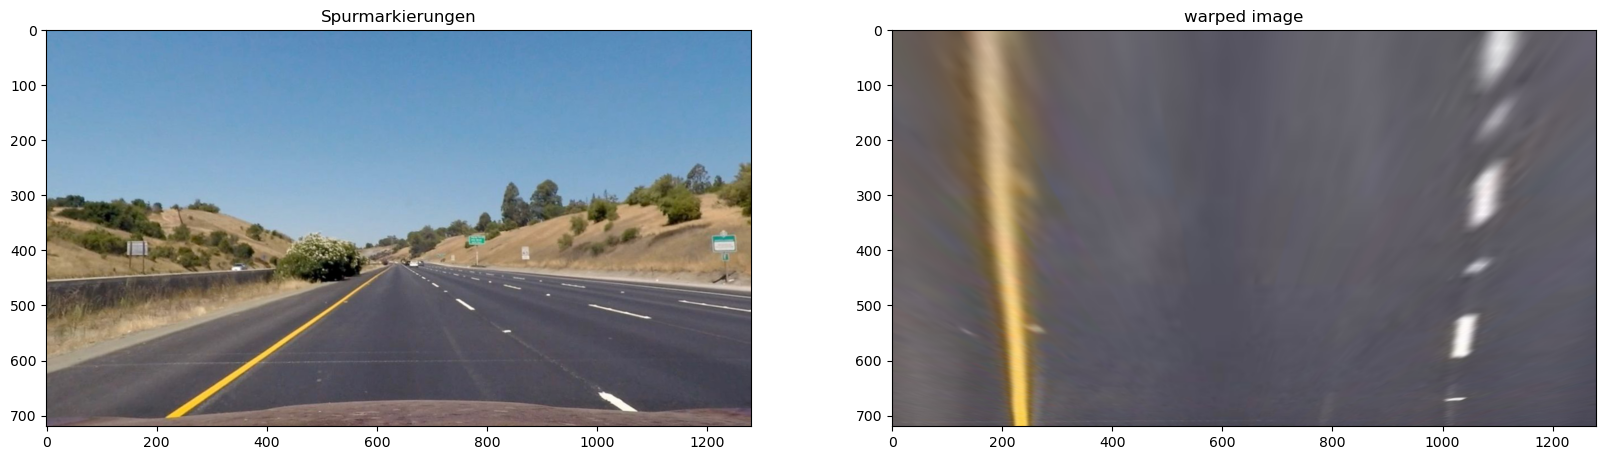

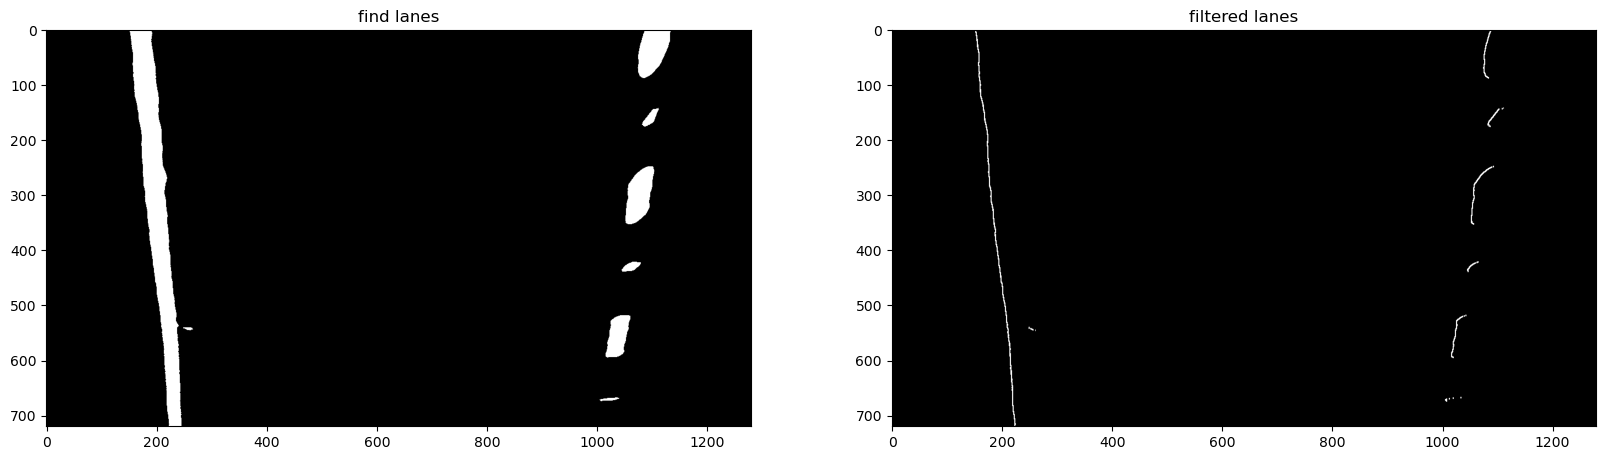

In [99]:
# Camera Calibrierung



# einlesen eines Beispielbildes
img1 = cv.imread('./img/Udacity/image001.jpg', -1)
plt.figure(figsize=(20,10))
plt.subplot(1,2,1)
plt.imshow(cv.cvtColor(img1, cv.COLOR_BGR2RGB))
plt.title('Original Image')

h,  w = img1.shape[:2]

# Anwenden Camera Kalibrierung
img1 = cv.undistort(img1, mtx, dist, None, mtx)
plt.subplot(1,2,2)
plt.imshow(cv.cvtColor(img1, cv.COLOR_BGR2RGB))
plt.title('Camera Calibrated Image')
plt.show()

# Anwenden Perspektivtransformation

# definieren Sie die für eine Perspektivtransformation notwendigen Quell- und Zielpunkte
src = np.float32(((580, 450), (700, 450), (220, 600), (1100, 600)))
dst = np.float32(((0, 0), (w, 0), (0, h), (w, h)))

plt.figure(figsize=(20,10))
plt.subplot(1,2,1)
plt.imshow(cv.cvtColor(img1, cv.COLOR_BGR2RGB))
plt.title('Spurmarkierungen')

M = cv.getPerspectiveTransform(src,dst)
img1_warp = cv.warpPerspective(img1,M,(img1.shape[1], img1.shape[0]))
plt.subplot(1,2,2)
plt.title("warped image")
plt.imshow(cv.cvtColor(img1_warp, cv.COLOR_BGR2RGB))
plt.show()#

img1_warp = cv.cvtColor(img1_warp, cv.COLOR_BGR2GRAY)

# Anwenden Morphologische Filter

black_white = np.where(img1_warp > 155, np.uint8(255), np.uint8(0))
plt.figure(figsize=(20,10))
plt.subplot(1,2,1)
plt.title("find lanes")
plt.imshow(black_white, cmap='gray')

kernel = np.array([[-1,0,1],[-1,0,1],[-1,0,1]],np.float32)
filtered = cv.filter2D(black_white,-1,kernel)

plt.subplot(1,2,2)
plt.title("filtered lanes")
plt.imshow(filtered, cmap='gray')

plt.show()

# Ausblick auf weitere Teilaufgaben
- Bestimmung der Kurvenkrümmung anhand von Polynom-Fiting